In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os 
from mne.datasets.limo import load_data
from mne.stats import linear_regression
from mne.viz import plot_events, plot_compare_evokeds
from mne import combine_evoked
from mne.minimum_norm import apply_inverse, make_inverse_operator, get_point_spread, make_inverse_resolution_matrix

import warnings
warnings.filterwarnings('ignore')

print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
limo_epochs = []
for subj in range(1,19):
    limo_epochs.append(load_data(subject=subj))


Adding metadata with 2 columns
Replacing existing metadata with 2 columns
1055 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Adding metadata with 2 columns
Replacing existing metadata with 2 columns
1052 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Adding metadata with 2 columns
Replacing existing metadata with 2 columns
1072 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Adding metadata with 2 columns
Replacing existing metadata with 2 columns
1050 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Adding metadata with 2 columns
Replacing existing metadata with 2 columns
1118 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Adding metadata with 2 columns
Replacing existing metadata with 2 columns
1108 matching ev

In [3]:
sbj2use = 0

phase_coh = limo_epochs[sbj2use].metadata['phase-coherence']
# get levels of phase coherence
levels = sorted(phase_coh.unique())
# create labels for levels of phase coherence (i.e., 0 - 85%)
labels = ["{0:.2f}".format(i) for i in np.arange(0., 0.90, 0.05)]

# create dict of evokeds for each level of phase-coherence
epocheds = {label: limo_epochs[sbj2use][phase_coh == level]
           for level, label in zip(levels, labels)}

In [8]:
thr2use = '0.85'

epoched = epocheds[thr2use]
ch_names = epoched.info.ch_names[:128]


ch_names_lower = np.array([x.lower() if isinstance(x, str) else x for x in ch_names])


standard_1020_montage = mne.channels.make_standard_montage('biosemi128')
standard_1020_ch_names_lower = np.array([x.lower() if isinstance(x, str) else x for x in standard_1020_montage.ch_names]).tolist()


pos_ordered = dict()

for x in range(0, len(ch_names)):
    index=standard_1020_ch_names_lower.index(ch_names_lower[x])
    ch_names[x]=standard_1020_montage.ch_names[index]
    pos_ordered[ch_names[x]] = standard_1020_montage.dig[index]['r']

    
nasion = standard_1020_montage.dig[1]['r']
lpa = standard_1020_montage.dig[0]['r']
rpa = standard_1020_montage.dig[2]['r']

montage = mne.channels.make_dig_montage(pos_ordered, nasion, lpa, rpa, coord_frame='mri')


Not setting metadata
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


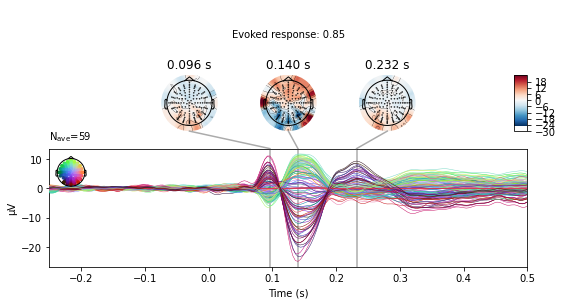

In [9]:
sfreq = 250
tmax = epoched.times[-1]

info = mne.create_info(ch_names=ch_names,sfreq=sfreq,ch_types='eeg')

epoched =mne.EpochsArray(epoched._data[:,:128,:],info,tmin=epoched.times[0]) 
epoched.set_montage(montage)
evoked = epoched.average()
evoked.set_eeg_reference('average', projection=True, verbose=False);
evoked.apply_baseline()
# only show -250 to 500 ms
ts_args = dict(xlim=(-0.25, 0.5))

ch, peak_locs1 = evoked.get_peak(ch_type='eeg', tmin=0.05, tmax=0.1)
ch, peak_locs2 = evoked.get_peak(ch_type='eeg', tmin=0.1, tmax=0.2)
ch, peak_locs3 = evoked.get_peak(ch_type='eeg', tmin=0.2, tmax=0.25)

times = [peak_locs1, peak_locs2, peak_locs3]

evoked.plot_joint(times=times, title='Evoked response: ' + thr2use , ts_args=ts_args);

## Frequency Analysis

We start by exploring the frequency content of our epochs.

Let’s first check out all channel types by averaging across epochs.

    Using multitaper spectrum estimation with 7 DPSS windows


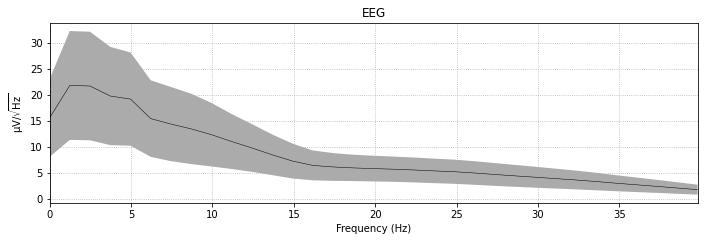

In [19]:
epoched.plot_psd(fmax=40,dB=False, average=True);

Now, let’s take a look at the spatial distributions of the PSD, averaged across epochs and frequency bands.

    Using multitaper spectrum estimation with 7 DPSS windows


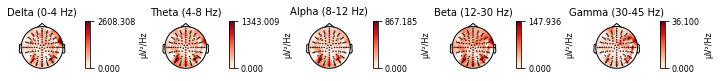

In [27]:
epoched.plot_psd_topomap(normalize=False, dB=False);


Alternatively, you can also create PSDs from Epochs with functions that start with psd_ such as mne.time_frequency.psd_multitaper() and mne.time_frequency.psd_welch().

Notably, mne.time_frequency.psd_welch() supports the keyword argument average, which specifies how to estimate the PSD based on the individual windowed segments. The default is average='mean', which simply calculates the arithmetic mean across segments. Specifying average='median', in contrast, returns the PSD based on the median of the segments (corrected for bias relative to the mean), which is a more robust measure.

Effective window size : 0.804 (s)
Effective window size : 0.804 (s)


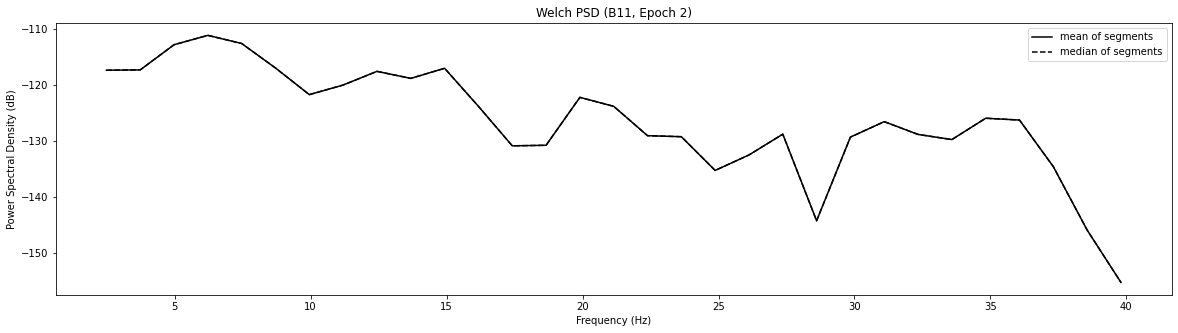

In [39]:
# Estimate PSDs based on "mean" and "median" averaging for comparison.
kwargs = dict(fmin=2, fmax=40, n_jobs=1, n_fft=201)
psds_welch_mean, freqs_mean = mne.time_frequency.psd_welch(epoched, average='mean', **kwargs)
psds_welch_median, freqs_median = mne.time_frequency.psd_welch(epoched, average='median', **kwargs)

# Convert power to dB scale.
psds_welch_mean = 10 * np.log10(psds_welch_mean)
psds_welch_median = 10 * np.log10(psds_welch_median)

# We will only plot the PSD for a single sensor in the first epoch.
ch_name = 'B11'
ch_idx = epoched.info['ch_names'].index(ch_name)
epo_idx = 2

_, ax = plt.subplots()
ax.plot(freqs_mean, psds_welch_mean[epo_idx, ch_idx, :], color='k',
        ls='-', label='mean of segments')
ax.plot(freqs_median, psds_welch_median[epo_idx, ch_idx, :], color='k',
        ls='--', label='median of segments')

ax.set(title='Welch PSD ({}, Epoch {})'.format(ch_name, epo_idx),
       xlabel='Frequency (Hz)', ylabel='Power Spectral Density (dB)')
ax.legend(loc='upper right')
plt.show()

## Time-frequency analysis: power and inter-trial coherence

We now compute time-frequency representations (TFRs) from our Epochs. We’ll look at power and inter-trial coherence (ITC).

To this we’ll use the function mne.time_frequency.tfr_morlet() but you can also use mne.time_frequency.tfr_multitaper() or mne.time_frequency.tfr_stockwell().

In [49]:
freqs = np.logspace(*np.log10([6, 35]), num=8)
n_cycles = freqs / 2.  # different number of cycle per frequency
power, itc = mne.time_frequency.tfr_morlet(epoched, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1)

Applying baseline correction (mode: logratio)


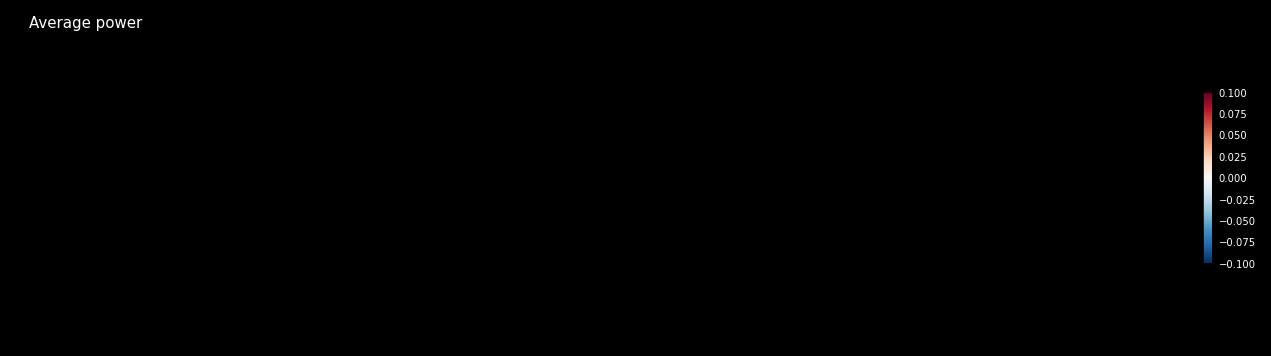

Applying baseline correction (mode: logratio)


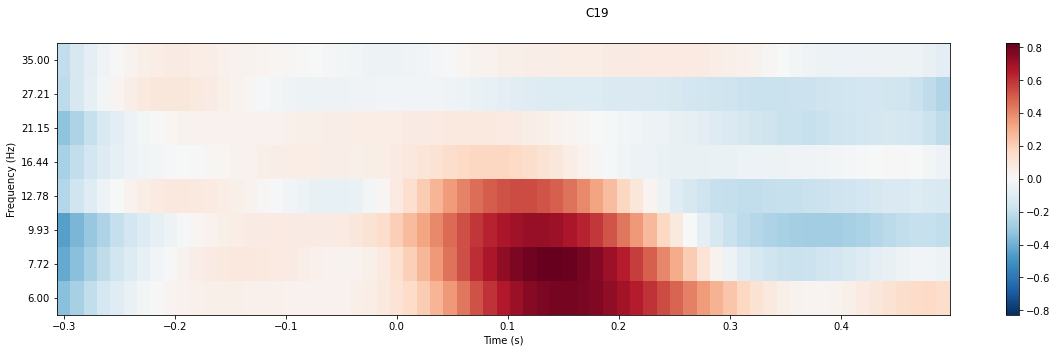

Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


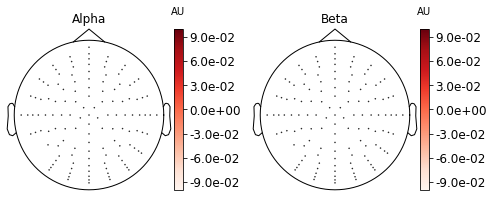

In [50]:
power.plot_topo(baseline=(-0.3, 0), mode='logratio', title='Average power')
power.plot([82], baseline=(-0.3, 0), mode='logratio', title=power.ch_names[82])

fig, axis = plt.subplots(1, 2, figsize=(7, 4))
power.plot_topomap(ch_type='eeg', tmin=0, tmax=0.3, fmin=8, fmax=12,
                   baseline=(-0.3, 0), mode='logratio', axes=axis[0],
                   title='Alpha', show=False)
power.plot_topomap(ch_type='eeg', tmin=0, tmax=0.3, fmin=13, fmax=25,
                   baseline=(-0.3, 0), mode='logratio', axes=axis[1],
                   title='Beta', show=False)
mne.viz.tight_layout()
plt.show()

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


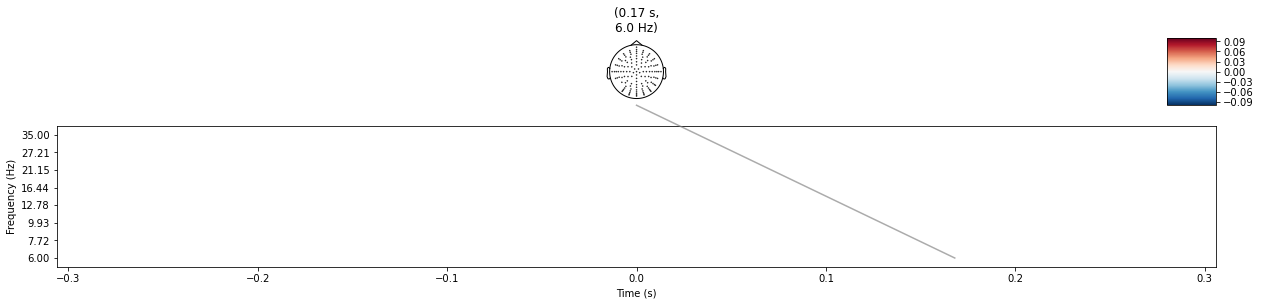

In [62]:
power.plot_joint(baseline=(-0.3, 0), mode='mean', tmin=-.3, tmax=0.3);

No baseline correction applied


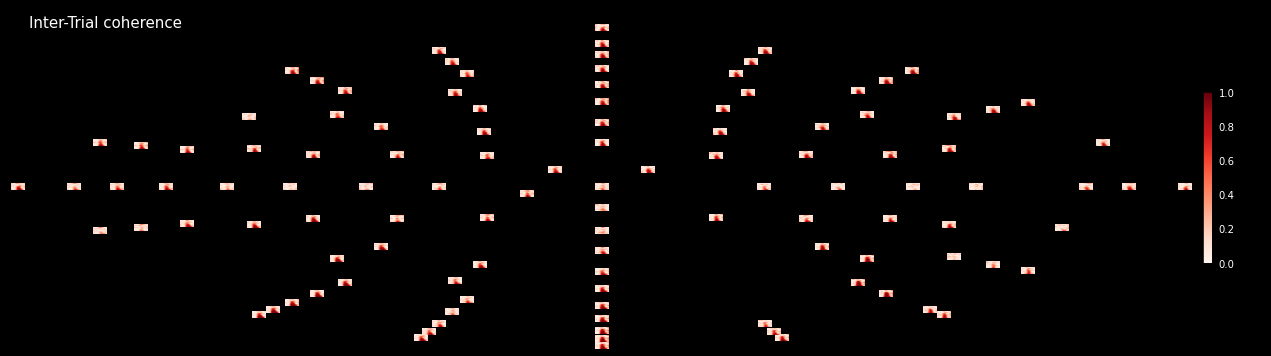

In [64]:
itc.plot_topo(title='Inter-Trial coherence', vmin=0., vmax=1., cmap='Reds');
